In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import keras_tuner as kt
import tensorflow as tf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from pyts.image import GramianAngularField
from sklearn.preprocessing import MinMaxScaler

## Step 1 ##

Let us consider the stock Asian Paints, which is traded on the Indian stock markets. We download the data from yfinance for the past 8 years.

In [4]:
stock = yf.Ticker("ASIANPAINT.NS").history(period="8y")

In [5]:
stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-02-27 00:00:00+05:30,953.300900,961.370911,942.918415,945.702820,738246,0.0,0.0
2017-02-28 00:00:00+05:30,946.788204,969.157808,942.116132,966.703674,1368244,0.0,0.0
2017-03-01 00:00:00+05:30,972.178121,981.616744,968.449912,974.773743,1124115,0.0,0.0
2017-03-02 00:00:00+05:30,979.634531,986.099963,968.780116,970.998169,1037442,0.0,0.0
2017-03-03 00:00:00+05:30,969.393685,969.393685,949.525341,956.793091,596208,0.0,0.0


In [6]:
stock.shape #less than 2000 rows of data, as stated in the GWP

(1977, 7)

For the analysis that follows, we consider just the closing price

In [8]:
data = stock["Close"]
data.head()

Date
2017-02-27 00:00:00+05:30    945.702820
2017-02-28 00:00:00+05:30    966.703674
2017-03-01 00:00:00+05:30    974.773743
2017-03-02 00:00:00+05:30    970.998169
2017-03-03 00:00:00+05:30    956.793091
Name: Close, dtype: float64

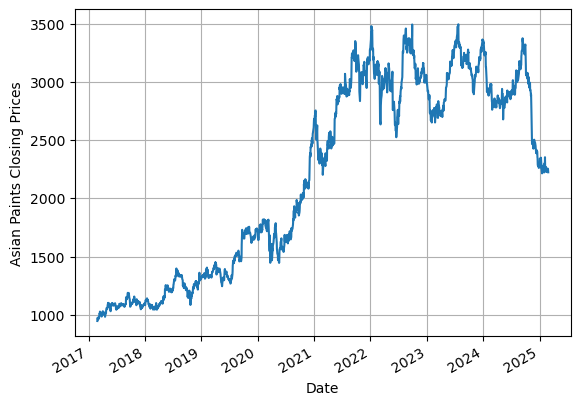

In [9]:
#Plot the time series
data.plot(ylabel="Asian Paints Closing Prices")
plt.grid()

The plot clearly shows a trend in the time series. The prices of the Asian Paints stock clearly rises with time.

In [11]:
data.describe() #summary statistics for the untransformed time series

count    1977.000000
mean     2198.306170
std       825.521090
min       945.702820
25%      1332.761719
50%      2324.152344
75%      2987.030029
max      3497.630127
Name: Close, dtype: float64

In [12]:
data.kurtosis()

-1.621242587715142

In [13]:
data.skew()

-0.09013814140417929

Note that the series has a high standard deviation of 827.44, and a mean of 2196.67.

Text(0.5, 1.0, 'Histogram of Asian Paints Closing Price')

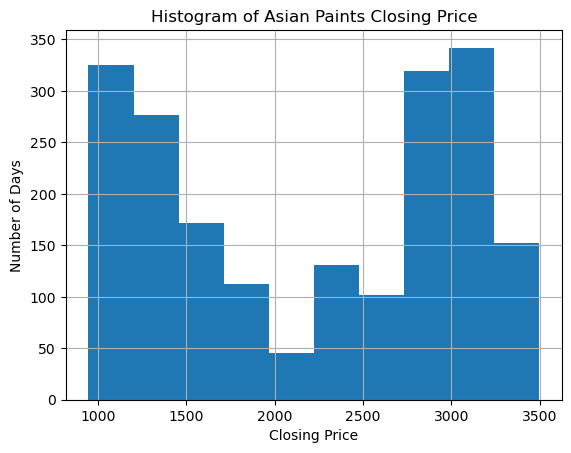

In [15]:
data.hist(bins = 10)
plt.xlabel("Closing Price")
plt.ylabel("Number of Days")
plt.title("Histogram of Asian Paints Closing Price")

Let us check for the presence of autocorrelation in the time series with different lags

In [17]:
for i in [1, 5, 10, 50, 100, 200, 500, 1000]:
    print(data.autocorr(lag = i))

0.999102217692773
0.9951753827772349
0.990476307894548
0.9481958982083459
0.9132216008458944
0.8836509774090279
0.6499354359417676
-0.37755338958131995


As you can see, the time series is heavily autocorrelated

Let us test for stationarity using the Augmented Dickey-Fuller test

In [20]:
adf_result_data = adfuller(data)
adf_statistic = adf_result_data[0] 
p_value = adf_result_data[1]
used_lags = adf_result_data[2] 
critical_values = adf_result_data[4] 

adf_statistic, p_value, used_lags, critical_values

(-1.551348799032068,
 0.5079743839767625,
 1,
 {'1%': -3.433665351698571,
  '5%': -2.8630045337025267,
  '10%': -2.567549656849864})

Note that the adf_statistic of -1.57 is higher than all the critical values. The p-value is 0.49 which is greater than 0.05. This means that we fail to reject the null hypothesis (that the series has a unit root). So, the untransformed time series for the Asian Paints NSE stock can be said be non-stationary.

In [22]:
differenced_data = data.diff()[1:]

In [23]:
differenced_data.head()

Date
2017-02-28 00:00:00+05:30    21.000854
2017-03-01 00:00:00+05:30     8.070068
2017-03-02 00:00:00+05:30    -3.775574
2017-03-03 00:00:00+05:30   -14.205078
2017-03-06 00:00:00+05:30    14.818665
Name: Close, dtype: float64

In [24]:
differenced_data.shape

(1976,)

Text(0, 0.5, 'Differenced Prices [Lag 1]')

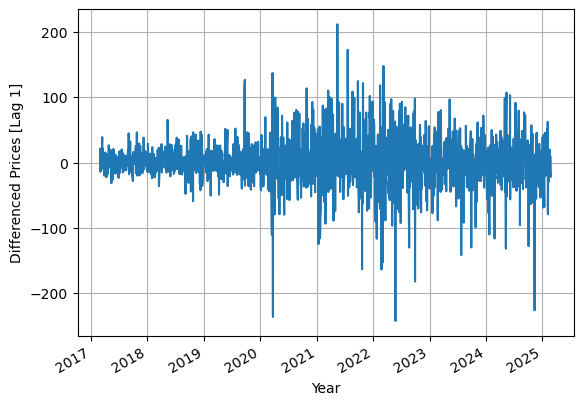

In [25]:
differenced_data.plot()
plt.grid()
plt.xlabel("Year")
plt.ylabel("Differenced Prices [Lag 1]")

In [26]:
for i in [1, 5, 10, 50, 100, 200, 500, 1000]:
    print(differenced_data.autocorr(lag = i))

0.04842387882085452
-0.013893753463466435
0.001699570285415424
-0.06202023106006024
-0.06143722711666369
0.005708349993168955
-0.01422187403095796
0.018341563971238258


In [27]:
differenced_data.describe()

count    1976.000000
mean        0.647291
std        34.982674
min      -242.193604
25%       -13.655182
50%         0.412048
75%        15.957428
max       211.207520
Name: Close, dtype: float64

In [28]:
differenced_data.kurtosis()

6.382510223698642

In [29]:
differenced_data.skew()

-0.4726691509492188

The differenced time series seems to be de-trended now. Let us now test for stationarity.

In [31]:
adf_result_differenced_data = adfuller(differenced_data)
adf_statistic = adf_result_differenced_data[0] 
p_value = adf_result_differenced_data[1]
used_lags = adf_result_differenced_data[2] 
critical_values = adf_result_differenced_data[4] 

adf_statistic, p_value, used_lags, critical_values

(-42.316512172846046,
 0.0,
 0,
 {'1%': -3.433665351698571,
  '5%': -2.8630045337025267,
  '10%': -2.567549656849864})

Here, note that the p value is zero and the adf_statistic of -42.31 is lesser than all the critical values, which implies that the differenced time series is stationary.

Now, let us attempt to implement fractional differencing

In [34]:
def getWeights(d,lags):
    # calculate the weights from the series expansion of the differencing operator
    # for real orders d and up to [lags] number of coefficients
    w=[1]
    for k in range(1,lags):
        w.append(-w[-1]*((d-k+1))/k)
    w=np.array(w).reshape(-1,1) 
    return w

In [35]:
def fractional_differencing(series, order, cutoff):
    #calculate the time series obtained from fractional differencing
    weights=getWeights(order, cutoff)
    frac_diff_series = 0
    for k in range(cutoff):
        frac_diff_series += weights[k]*series.shift(k).fillna(0)
    return frac_diff_series[cutoff:] 

In [36]:
frac_diff_series = fractional_differencing(data, 0.9, 10) #considering d = 0.75 for now and we consider 10 terms in the series

Text(0, 0.5, 'Series After Fractional Differencing with d = 0.9')

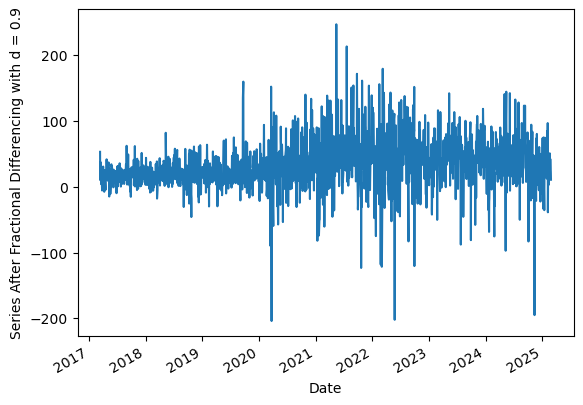

In [37]:
frac_diff_series.plot()
plt.ylabel("Series After Fractional Differencing with d = 0.9")

In [38]:
frac_diff_series.describe()

count    1967.000000
mean       32.661540
std        36.960974
min      -204.009096
25%        12.120364
50%        29.038443
75%        51.204275
max       246.927981
Name: Close, dtype: float64

In [39]:
frac_diff_series.kurtosis()

4.61308216391883

In [40]:
frac_diff_series.skew()

-0.0022268919276088087

In [41]:
frac_diff_series.shape

(1967,)

In [42]:
adf_result_frac_diff_data = adfuller(frac_diff_series)
adf_statistic = adf_result_frac_diff_data[0] 
p_value = adf_result_frac_diff_data[1]
used_lags = adf_result_frac_diff_data[2] 
critical_values = adf_result_frac_diff_data[4] 

adf_statistic, p_value, used_lags, critical_values

(-4.577150259787551,
 0.00014229271926595485,
 26,
 {'1%': -3.4337252441664483,
  '5%': -2.8630309758314314,
  '10%': -2.56756373605059})

Note that for this fractional differenced series with d = 0.75, the adf_statistic is higher than the critical values. The p-value of 0.22 also indicates that this fractional differenced series is not stationary.

## Step 2 

Let us now build Multi-Layer Perceptron models to predict the future values of these time series. Specifically, we predict if the stock will rise or fall the next day.

**First, the original time series.** he inputs to this model will be the returns over the past 10, 60, 150 days along with the present value.

In [778]:
data_mlp = data.to_frame()

In [780]:
data_mlp["1d_returns"] = data.pct_change()

In [782]:
data_mlp.head()

,Close,1d_returns
Date,,
2017-02-27 00:00:00+05:30,945.702759,NaN
2017-02-28 00:00:00+05:30,966.703613,0.022207
2017-03-01 00:00:00+05:30,974.773682,0.008348
2017-03-02 00:00:00+05:30,970.998230,-0.003873
2017-03-03 00:00:00+05:30,956.793152,-0.014629


In [784]:
data_mlp["10d_returns"] = data_mlp["1d_returns"].rolling(10).apply(lambda x: (1+ x).prod())
data_mlp["60d_returns"] = data_mlp["1d_returns"].rolling(60).apply(lambda x: (1+ x).prod())
data_mlp["150d_returns"] = data_mlp["1d_returns"].rolling(150).apply(lambda x: (1+ x).prod())

In [785]:
data_mlp.dropna(inplace=True)

In [786]:
data_mlp.head()

,Close,1d_returns,10d_returns,60d_returns,150d_returns
Date,,,,,
2017-10-05 00:00:00+05:30,1090.405762,-0.000694,0.932069,1.022611,1.153011
2017-10-06 00:00:00+05:30,1094.235718,0.003512,0.941583,1.022576,1.131925
2017-10-09 00:00:00+05:30,1095.464600,0.001123,0.954956,1.021963,1.123814
2017-10-10 00:00:00+05:30,1099.624878,0.003798,0.971636,1.033318,1.132468
2017-10-11 00:00:00+05:30,1097.355469,-0.002064,0.988586,1.038708,1.146910


In [790]:
data_mlp.shape

(1827, 5)

now, we create a separate column for the returns the next day. For this, we can simply shift the 1d_returns column by one day. We treat this as a classfication task and try to predict if the returns next dat will be positive or negative.

In [793]:
data_mlp["next_10d_returns"] = (data_mlp["10d_returns"].shift(10)>0).astype(int) #this is our target column. 
data_mlp.dropna(inplace=True)

In [795]:
data_mlp.head()

,Close,1d_returns,10d_returns,60d_returns,150d_returns,next_10d_returns
Date,,,,,,
2017-10-05 00:00:00+05:30,1090.405762,-0.000694,0.932069,1.022611,1.153011,0
2017-10-06 00:00:00+05:30,1094.235718,0.003512,0.941583,1.022576,1.131925,0
2017-10-09 00:00:00+05:30,1095.464600,0.001123,0.954956,1.021963,1.123814,0
2017-10-10 00:00:00+05:30,1099.624878,0.003798,0.971636,1.033318,1.132468,0
2017-10-11 00:00:00+05:30,1097.355469,-0.002064,0.988586,1.038708,1.146910,0


In [796]:
X = data_mlp[['1d_returns', '10d_returns', '60d_returns', '150d_returns']]
y = data_mlp['next_10d_returns']

In [799]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) #train-test split

Now to build the MLP

In [802]:
tf.keras.backend.clear_session()  # We clear the backend to reset the random seed process
tf.random.set_seed(42)

act_fun = "relu"
hp_units_1 = 4
hp_units_2 = 4
n_dropout = 0.2

In [818]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=hp_units_1, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) #activation function

In [820]:
hp_lr = 1e-4  # Learning rate
adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)  # Adam optimizer
model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

In [822]:
y_train.value_counts()

next_10d_returns
1    1451
0      10
Name: count, dtype: int64

In [824]:
class_weight = {0: 1 / (1 - np.mean(y_train)), 1: 1.0}

In [826]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=2,
    class_weight=class_weight
)

Epoch 1/100
37/37 - 3s - 82ms/step - accuracy: 0.9221 - loss: 1.8556 - val_accuracy: 1.0000 - val_loss: 0.3991
Epoch 2/100
37/37 - 0s - 7ms/step - accuracy: 0.9058 - loss: 2.0137 - val_accuracy: 1.0000 - val_loss: 0.4028
Epoch 3/100
37/37 - 0s - 7ms/step - accuracy: 0.9238 - loss: 1.9539 - val_accuracy: 1.0000 - val_loss: 0.4065
Epoch 4/100
37/37 - 0s - 6ms/step - accuracy: 0.9101 - loss: 1.9269 - val_accuracy: 1.0000 - val_loss: 0.4095
Epoch 5/100
37/37 - 0s - 6ms/step - accuracy: 0.9118 - loss: 1.6923 - val_accuracy: 1.0000 - val_loss: 0.4118
Epoch 6/100
37/37 - 0s - 8ms/step - accuracy: 0.9161 - loss: 1.7244 - val_accuracy: 1.0000 - val_loss: 0.4134
Epoch 7/100
37/37 - 0s - 8ms/step - accuracy: 0.9110 - loss: 1.7709 - val_accuracy: 1.0000 - val_loss: 0.4158
Epoch 8/100
37/37 - 0s - 7ms/step - accuracy: 0.9067 - loss: 1.5673 - val_accuracy: 1.0000 - val_loss: 0.4174
Epoch 9/100
37/37 - 0s - 6ms/step - accuracy: 0.9144 - loss: 1.8234 - val_accuracy: 1.0000 - val_loss: 0.4199
Epoch 10/

In [832]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 137 (552.00 B)

 Trainable params: 45 (180.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 92 (372.00 B)

In [834]:
y_prob = model.predict(X_test)
y_pred = np.where(y_prob > 0.50, 1, 0)

acc = model.evaluate(X_test, y_test)
print("Model accuracy in test: ", acc) #outputs the loss and the accuracy

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.6143 
Model accuracy in test:  [0.6175158023834229, 1.0]


In [840]:
result = confusion_matrix(y_test, y_pred, normalize='pred')
result

C:\Users\susha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


array([[1.]])

**Now, let us similarly try to create a predictive model for the differenced series.**

In [842]:
differenced_data_mlp = differenced_data.to_frame()

In [844]:
differenced_data_mlp.head()

,Close
Date,
2017-02-28 00:00:00+05:30,21.000854
2017-03-01 00:00:00+05:30,8.070068
2017-03-02 00:00:00+05:30,-3.775452
2017-03-03 00:00:00+05:30,-14.205078
2017-03-06 00:00:00+05:30,14.818726


In [846]:
differenced_data_mlp["1d_returns"] = differenced_data_mlp["Close"].pct_change()
differenced_data_mlp["2d_returns"] = differenced_data_mlp["1d_returns"].rolling(2).apply(lambda x: (1 + x).prod())
differenced_data_mlp["10d_returns"] = differenced_data_mlp["1d_returns"].rolling(10).apply(lambda x: (1 + x).prod())

In [847]:
differenced_data_mlp["next_10d_returns"] = (differenced_data_mlp["10d_returns"].shift(10)>0).astype(int)  #this is our target column. 

In [848]:
differenced_data_mlp.isnull().sum()

Close                0
1d_returns           1
2d_returns          12
10d_returns         60
next_10d_returns     0
dtype: int64

In [852]:
differenced_data_mlp.shape

(1976, 5)

In [854]:
differenced_data_mlp.dropna(inplace=True)

In [856]:
differenced_data_mlp.shape

(1916, 5)

In [858]:
X = differenced_data_mlp[['1d_returns', '2d_returns', '10d_returns']]
y = differenced_data_mlp['next_10d_returns']

In [860]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) #train-test split

In [862]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=hp_units_1, activation=act_fun))
#model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
#model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
#model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) #activation function

In [864]:
hp_lr = 1e-4  # Learning rate
adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)  # Adam optimizer
model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

In [866]:
y_train.value_counts()

next_10d_returns
0    797
1    735
Name: count, dtype: int64

In [868]:
class_weight = {0: 1 / (1 - np.mean(y_train)), 1: 1.0}

In [870]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=2,
)

Epoch 1/100
39/39 - 3s - 73ms/step - accuracy: 0.5151 - loss: 0.8054 - val_accuracy: 0.4691 - val_loss: 0.7310
Epoch 2/100
39/39 - 0s - 6ms/step - accuracy: 0.5143 - loss: 0.7984 - val_accuracy: 0.4691 - val_loss: 0.7289
Epoch 3/100
39/39 - 0s - 6ms/step - accuracy: 0.5135 - loss: 0.7915 - val_accuracy: 0.4658 - val_loss: 0.7269
Epoch 4/100
39/39 - 0s - 6ms/step - accuracy: 0.5110 - loss: 0.7850 - val_accuracy: 0.4560 - val_loss: 0.7250
Epoch 5/100
39/39 - 0s - 6ms/step - accuracy: 0.5135 - loss: 0.7787 - val_accuracy: 0.4593 - val_loss: 0.7233
Epoch 6/100
39/39 - 0s - 6ms/step - accuracy: 0.5135 - loss: 0.7727 - val_accuracy: 0.4528 - val_loss: 0.7218
Epoch 7/100
39/39 - 0s - 6ms/step - accuracy: 0.5159 - loss: 0.7671 - val_accuracy: 0.4560 - val_loss: 0.7203
Epoch 8/100
39/39 - 0s - 6ms/step - accuracy: 0.5176 - loss: 0.7619 - val_accuracy: 0.4625 - val_loss: 0.7190
Epoch 9/100
39/39 - 0s - 6ms/step - accuracy: 0.5200 - loss: 0.7569 - val_accuracy: 0.4625 - val_loss: 0.7178
Epoch 10/

In [871]:
y_prob = model.predict(X_test)
y_pred = np.where(y_prob > 0.50, 1, 0)

acc = model.evaluate(X_test, y_test)
print("Model accuracy in test: ", acc) #outputs the loss and the accuracy

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5556 - loss: 0.6953 
Model accuracy in test:  [0.6983429789543152, 0.5546875]


**Now, let us similarly try to create a predictive model for the fractionally differenced series.**

In [912]:
frac_diff_series_mlp = frac_diff_series.to_frame()

In [914]:
frac_diff_series_mlp.shape

(1967, 1)

In [916]:
frac_diff_series_mlp["1d_returns"] = frac_diff_series.pct_change()

In [918]:
frac_diff_series_mlp["10d_returns"] = frac_diff_series_mlp["1d_returns"].rolling(10).apply(lambda x: (1+ x).prod())
frac_diff_series_mlp["60d_returns"] = frac_diff_series_mlp["1d_returns"].rolling(60).apply(lambda x: (1+ x).prod())
frac_diff_series_mlp["150d_returns"] = frac_diff_series_mlp["1d_returns"].rolling(150).apply(lambda x: (1+ x).prod())

In [919]:
frac_diff_series_mlp.dropna(inplace=True)

In [920]:
frac_diff_series_mlp.shape

(1817, 5)

In [921]:
frac_diff_series_mlp["next_10d_returns"] = (frac_diff_series_mlp["10d_returns"].shift(10)>0).astype(int) #this is our target column. 
frac_diff_series_mlp.dropna(inplace=True)

In [922]:
X = frac_diff_series_mlp[['1d_returns', '10d_returns', '60d_returns', '150d_returns']]
y = frac_diff_series_mlp['next_10d_returns']

In [928]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) #train-test split

In [930]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=hp_units_1, activation=act_fun))
#model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
#model.add(tf.keras.layers.Dropout(n_dropout))
#model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) #activation function

In [932]:
hp_lr = 1e-3  # Learning rate
adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)  # Adam optimizer
model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

In [934]:
y_train.value_counts()

next_10d_returns
1    1163
0     290
Name: count, dtype: int64

In [936]:
class_weight = {0: 1 / (1 - np.mean(y_train)), 1: 1.0}
 #balancing the classes

In [938]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100, 
    batch_size=32,
    verbose=2,
    class_weight=class_weight
)

Epoch 1/100
37/37 - 3s - 88ms/step - accuracy: 0.2091 - loss: 1.2345 - val_accuracy: 0.1615 - val_loss: 0.9911
Epoch 2/100
37/37 - 0s - 6ms/step - accuracy: 0.2091 - loss: 1.2151 - val_accuracy: 0.1615 - val_loss: 0.9714
Epoch 3/100
37/37 - 0s - 7ms/step - accuracy: 0.2091 - loss: 1.2048 - val_accuracy: 0.1615 - val_loss: 0.9573
Epoch 4/100
37/37 - 0s - 7ms/step - accuracy: 0.2091 - loss: 1.1970 - val_accuracy: 0.1615 - val_loss: 0.9593
Epoch 5/100
37/37 - 0s - 7ms/step - accuracy: 0.2091 - loss: 1.1909 - val_accuracy: 0.1615 - val_loss: 0.9591
Epoch 6/100
37/37 - 0s - 8ms/step - accuracy: 0.2091 - loss: 1.1849 - val_accuracy: 0.1615 - val_loss: 0.9568
Epoch 7/100
37/37 - 0s - 7ms/step - accuracy: 0.2091 - loss: 1.1790 - val_accuracy: 0.1615 - val_loss: 0.9391
Epoch 8/100
37/37 - 0s - 8ms/step - accuracy: 0.2091 - loss: 1.1730 - val_accuracy: 0.1615 - val_loss: 0.9249
Epoch 9/100
37/37 - 0s - 8ms/step - accuracy: 0.3107 - loss: 1.1672 - val_accuracy: 0.4021 - val_loss: 0.9157
Epoch 10/

In [940]:
y_prob = model.predict(X_test)
y_pred = np.where(y_prob > 0.50, 1, 0)

acc = model.evaluate(X_test, y_test);
print("Model accuracy in test: ", acc); #outputs the loss and the accuracy

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7210 - loss: 0.6497 
Model accuracy in test:  [0.6524090766906738, 0.708791196346283]


In [942]:
result = confusion_matrix(y_test, y_pred)
result

array([[ 35,  26],
       [ 80, 223]], dtype=int64)

**Of the three series, the MLP model gets the best test accuracy for the original time series and the worst for the differenced time series. This counter-intuitively shows that removing the trend from the time series is probably not a good idea. However, let us now proceed to build our CNN model and see how it fares.**

## Step 3 

Now the build the Convolutional Neural Network Model

(1938, 30)


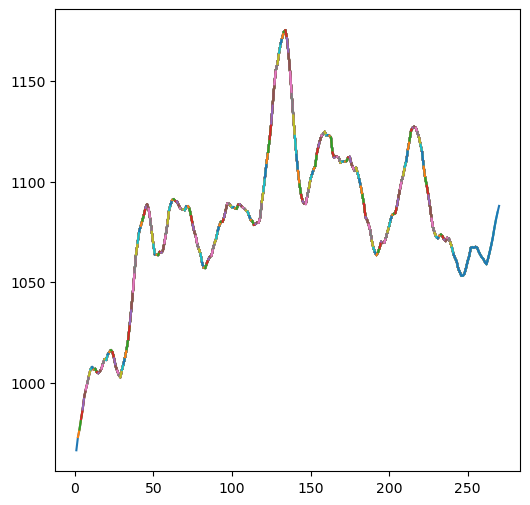

In [74]:
scaler = MinMaxScaler()
data = data.rolling(10).mean().dropna()
data_scaled = scaler.fit_transform(data.to_frame())

X_train = []
window_size = 30
for i in range(window_size, data_scaled.shape[0]):
    X_train.append(data[i - window_size : i])
X_train = np.array(X_train)
print(X_train.shape)
# Define a "window_size"-days interval
days = np.linspace(1, X_train.shape[0], num=X_train.shape[0])
# Plot the overlapping time series
plt.figure(figsize=(6, 6))
for i in range(241):
    plt.plot(days[i : window_size + i], X_train[i, :])

In [76]:
transformer = GramianAngularField()
X_train_new = transformer.transform(X_train)
print(X_train_new.shape)

(1938, 30, 30)


In [77]:
# Generate the labels: 1 if price goes up after window_size days, 0 otherwise
y_data = []
for i in range(window_size, data.shape[0] - window_size):
    y_data.append(data[i] < data[i + window_size])
y_data = np.array(y_data)
y_data.shape

C:\Users\susha\AppData\Local\Temp\ipykernel_13592\1383070507.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_data.append(data[i] < data[i + window_size])


(1908,)

In [78]:
# Determine the examples to be used as inputs in the model and rescale them to the [0,255] scale
X_data = X_train_new[:-window_size]
for i in range(X_data.shape[0]):
    X_data[i] = (X_data[i] - np.min(X_data[i])) / (
        np.max(X_data[i]) - np.min(X_data[i])
    )
# We could simply write X_data = (X_data + 1)/2
X_data = X_data * 255
X_data.shape

(1908, 30, 30)

In [79]:
# Split into train and test
train_split = 0.8
y_data_train = y_data[: int(train_split * y_data.shape[0])]
y_data_test = y_data[int(train_split * y_data.shape[0]) :]
X_data_train = X_data[: int(train_split * y_data.shape[0])]
X_data_test = X_data[int(train_split * y_data.shape[0]) :]

In [80]:
model = tf.keras.Sequential()
# Input layer
model.add(tf.keras.layers.InputLayer(input_shape=(30, 30, 1)))
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32, activation="relu"))
#model.add(tf.keras.layers.Dropout(0.2, seed=1234))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [81]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 12, 12, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,553 (123.25 KB)

 Trainable params: 31,553 (123.25 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
model.compile(loss="binary_crossentropy", optimizer="RMSprop", metrics=["accuracy"])
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5", monitor="val_accuracy", save_best_only=True, mode="auto"
)
class_weight = {0: 1 / (1 - np.mean(y_data_train)), 1: 1.0}
print(class_weight)

{0: 2.577702702702703, 1: 1.0}


In [90]:
model.fit(
    x=X_data_train,
    y=y_data_train,
    epochs=20,
    validation_data=(X_data_test, y_data_test),
    verbose=1,
    callbacks=[checkpoint],
    class_weight=class_weight,
)

Epoch 1/20
45/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5135 - loss: 8.6315

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5124 - loss: 8.2008 - val_accuracy: 0.5628 - val_loss: 0.7489
Epoch 2/20
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4586 - loss: 1.0776

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4579 - loss: 1.0799 - val_accuracy: 0.6126 - val_loss: 0.6890
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4046 - loss: 1.0557 - val_accuracy: 0.5340 - val_loss: 0.7762
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4319 - loss: 1.1052 - val_accuracy: 0.5550 - val_loss: 0.9825
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4568 - loss: 1.0731 - val_accuracy: 0.5812 - val_loss: 0.7099
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4636 - loss: 1.0321 - val_accuracy: 0.5576 - val_loss: 0.7486
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4724 - loss: 1.0025 - val_accuracy: 0.5812 - val_loss: 0.7342
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4790 - loss: 1.0195 - val_accuracy: 0.5157 - val_loss: 0.9994
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5135 - loss: 0.9863 - val_accuracy: 0.5524 - val_loss: 0.

In [91]:
model = tf.keras.models.load_model("model.h5")
acc = model.evaluate(x=X_data_test, y=y_data_test)
print("Accuracy over validation: {:.2f}%".format(acc[1] * 100))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6652 - loss: 0.6667  
Accuracy over validation: 61.26%


Now, attempting the same for the differenced time series

(1937, 30)


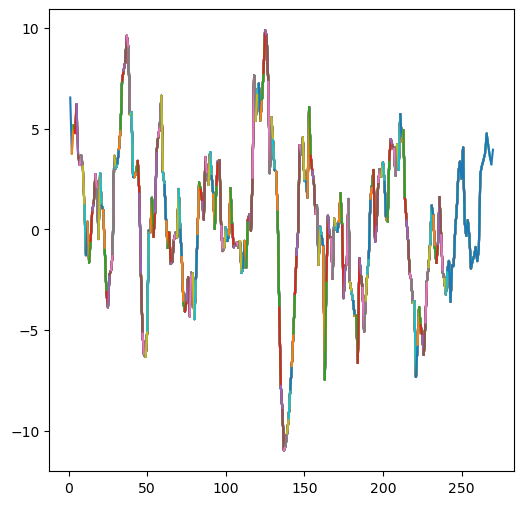

In [131]:
differenced_data = differenced_data.rolling(10).mean().dropna()
differenced_data_scaled = scaler.fit_transform(differenced_data.to_frame())

X_train = []
window_size = 30
for i in range(window_size, differenced_data.shape[0]):
    X_train.append(differenced_data[i - window_size : i])
X_train = np.array(X_train)
print(X_train.shape)
# Define a "window_size"-days interval
days = np.linspace(1, X_train.shape[0], num=X_train.shape[0])
# Plot the overlapping time series
plt.figure(figsize=(6, 6))
for i in range(241):
    plt.plot(days[i : window_size + i], X_train[i, :])

In [133]:
transformer = GramianAngularField()
X_train_new = transformer.transform(X_train)
print(X_train_new.shape)

(1937, 30, 30)


In [135]:
# Generate the labels: 1 if price goes up after window_size days, 0 otherwise
y_data = []
for i in range(window_size, differenced_data.shape[0] - window_size):
    y_data.append(differenced_data[i] < differenced_data[i + window_size])
y_data = np.array(y_data)
y_data.shape

C:\Users\susha\AppData\Local\Temp\ipykernel_13592\1183533469.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_data.append(differenced_data[i] < differenced_data[i + window_size])


(1907,)

In [137]:
# Determine the examples to be used as inputs in the model and rescale them to the [0,255] scale
X_data = X_train_new[:-window_size]
for i in range(X_data.shape[0]):
    X_data[i] = (X_data[i] - np.min(X_data[i])) / (
        np.max(X_data[i]) - np.min(X_data[i])
    )
# We could simply write X_data = (X_data + 1)/2
X_data = X_data * 255
X_data.shape

(1907, 30, 30)

In [139]:
# Split into train and test
train_split = 0.8
y_data_train = y_data[: int(train_split * y_data.shape[0])]
y_data_test = y_data[int(train_split * y_data.shape[0]) :]
X_data_train = X_data[: int(train_split * y_data.shape[0])]
X_data_test = X_data[int(train_split * y_data.shape[0]) :]

In [141]:
model = tf.keras.Sequential()
# Input layer
model.add(tf.keras.layers.InputLayer(input_shape=(30, 30, 1)))
#model.add(tf.keras.layers.Conv2D(16, (3, 3), activation="relu"))
#model.add(tf.keras.layers.MaxPooling2D((2, 2)))
#model.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu"))
#model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation="relu"))
#model.add(tf.keras.layers.Dropout(0.5, seed=1234))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [143]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 803,585 (3.07 MB)

 Trainable params: 803,585 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

In [145]:
model.compile(loss="binary_crossentropy", optimizer="RMSprop", metrics=["accuracy"])
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5", monitor="val_accuracy", save_best_only=True, mode="auto"
)
class_weight = {0: 1 / (1 - np.mean(y_data_train)), 1: 1.0}
print(class_weight)

{0: 2.115117891816921, 1: 1.0}


In [147]:
model.fit(
    x=X_data_train,
    y=y_data_train,
    epochs=10,
    validation_data=(X_data_test, y_data_test),
    verbose=1,
    callbacks=[checkpoint],
    class_weight=class_weight,
)

Epoch 1/10
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4843 - loss: 63.0211

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.4850 - loss: 60.8854 - val_accuracy: 0.4686 - val_loss: 1.8531
Epoch 2/10
45/48 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5209 - loss: 2.8493

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5224 - loss: 2.7918 - val_accuracy: 0.5288 - val_loss: 0.9410
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6288 - loss: 0.9207 - val_accuracy: 0.5157 - val_loss: 0.8165
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7739 - loss: 0.6409 - val_accuracy: 0.5079 - val_loss: 1.0443
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8671 - loss: 0.4382 - val_accuracy: 0.4398 - val_loss: 1.1093
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9358 - loss: 0.2748 - val_accuracy: 0.4372 - val_loss: 1.3372
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9718 - loss: 0.1458 - val_accuracy: 0.4319 - val_loss: 1.7860
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9862 - loss: 0.0837 - val_accuracy: 0.4503 - val_loss: 1.7363
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9942 - loss: 0.0420 - val_accuracy: 0.4738 - val_loss: 2.

In [148]:
model = tf.keras.models.load_model("model.h5")
acc = model.evaluate(x=X_data_test, y=y_data_test)
print("Accuracy over validation: {:.2f}%".format(acc[1] * 100))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5997 - loss: 0.8614
Accuracy over validation: 52.88%


Now for the fractionally Differenced Series

(1928, 30)


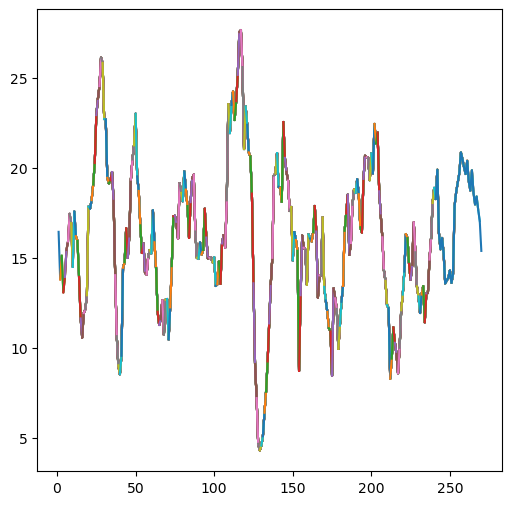

In [111]:
frac_diff_series = frac_diff_series.rolling(10).mean().dropna()
frac_diff_data_scaled = scaler.fit_transform(frac_diff_series.to_frame())

X_train = []
window_size = 30
for i in range(window_size, frac_diff_data_scaled.shape[0]):
    X_train.append(frac_diff_series[i - window_size : i])
X_train = np.array(X_train)
print(X_train.shape)
# Define a "window_size"-days interval
days = np.linspace(1, X_train.shape[0], num=X_train.shape[0])
# Plot the overlapping time series
plt.figure(figsize=(6, 6))
for i in range(241):
    plt.plot(days[i : window_size + i], X_train[i, :])

In [112]:
transformer = GramianAngularField()
X_train_new = transformer.transform(X_train)
print(X_train_new.shape)

(1928, 30, 30)


In [115]:
# Generate the labels: 1 if price goes up after window_size days, 0 otherwise
y_data = []
for i in range(window_size, frac_diff_series.shape[0] - window_size):
    y_data.append(frac_diff_series[i] < frac_diff_series[i + window_size])
y_data = np.array(y_data)
y_data.shape

C:\Users\susha\AppData\Local\Temp\ipykernel_13592\393614003.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_data.append(frac_diff_series[i] < frac_diff_series[i + window_size])


(1898,)

In [117]:
# Determine the examples to be used as inputs in the model and rescale them to the [0,255] scale
X_data = X_train_new[:-window_size]
for i in range(X_data.shape[0]):
    X_data[i] = (X_data[i] - np.min(X_data[i])) / (
        np.max(X_data[i]) - np.min(X_data[i])
    )
# We could simply write X_data = (X_data + 1)/2
X_data = X_data * 255
X_data.shape

(1898, 30, 30)

In [119]:
# Split into train and test
train_split = 0.8
y_data_train = y_data[: int(train_split * y_data.shape[0])]
y_data_test = y_data[int(train_split * y_data.shape[0]) :]
X_data_train = X_data[: int(train_split * y_data.shape[0])]
X_data_test = X_data[int(train_split * y_data.shape[0]) :]

In [121]:
model = tf.keras.Sequential()
# Input layer
model.add(tf.keras.layers.InputLayer(input_shape=(30, 30, 1)))
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation="relu"))
#model.add(tf.keras.layers.Dropout(0.5, seed=1234))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [123]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 4, 4, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,809 (155.50 KB)

 Trainable params: 39,809 (155.50 KB)

 Non-trainable params: 0 (0.00 B)

In [125]:
model.compile(loss="binary_crossentropy", optimizer="RMSprop", metrics=["accuracy"])
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5", monitor="val_accuracy", save_best_only=True, mode="auto"
)
class_weight = {0: 1 / (1 - np.mean(y_data_train)), 1: 1.0}
print(class_weight)

{0: 2.209606986899563, 1: 1.0}


In [127]:
model.fit(
    x=X_data_train,
    y=y_data_train,
    epochs=10,
    validation_data=(X_data_test, y_data_test),
    verbose=1,
    callbacks=[checkpoint],
    class_weight=class_weight,
)

Epoch 1/10
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5102 - loss: 8.0268

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5103 - loss: 7.7621 - val_accuracy: 0.5053 - val_loss: 1.0516
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5202 - loss: 1.2275 - val_accuracy: 0.4579 - val_loss: 0.7760
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5622 - loss: 1.0420 - val_accuracy: 0.5053 - val_loss: 0.7361
Epoch 4/10
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6178 - loss: 0.9074

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6170 - loss: 0.9087 - val_accuracy: 0.5447 - val_loss: 0.7799
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6258 - loss: 0.8718 - val_accuracy: 0.5132 - val_loss: 0.8032
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7066 - loss: 0.7567 - val_accuracy: 0.5447 - val_loss: 0.7973
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7163 - loss: 0.7298 - val_accuracy: 0.5184 - val_loss: 2.3526
Epoch 8/10
41/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7626 - loss: 0.7504

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7644 - loss: 0.7355 - val_accuracy: 0.5553 - val_loss: 0.9639
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8252 - loss: 0.5232 - val_accuracy: 0.5500 - val_loss: 1.1273
Epoch 10/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8497 - loss: 0.4485 - val_accuracy: 0.5184 - val_loss: 1.1479


In [128]:
model = tf.keras.models.load_model("model.h5")
acc = model.evaluate(x=X_data_test, y=y_data_test)
print("Accuracy over validation: {:.2f}%".format(acc[1] * 100))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5626 - loss: 0.9381
Accuracy over validation: 55.53%
